In [1]:
!pip install -q sklearn
!pip install -q pytorch-tabnet

# Imports

In [2]:
import pandas as pd
import numpy as np
import random
import os
import time

import dask
from dask_saturn import SaturnCluster
from dask.distributed import Client

import seaborn as sns
import matplotlib.pyplot as plt

# import torch
from pytorch_tabnet.tab_model import TabNetRegressor

from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import mean_squared_log_error

In [3]:
cluster = SaturnCluster()
client = Client(cluster)
client

INFO:dask-saturn:Cluster is ready
INFO:dask-saturn:Registering default plugins
INFO:dask-saturn:Success!


Client Scheduler: tcp://d-natha-pytorch-387c83827a0847898c7ae2605dbeb461.main-namespace:8786 Dashboard: https://d-natha-pytorch-387c83827a0847898c7ae2605dbeb461.community.saturnenterprise.io,Cluster Workers: 3 Cores: 12 Memory: 43.31 GiB


In [4]:
def install():
    os.system("pip install -q pytorch-tabnet")
    
client.run(install)

{'tcp://192.168.125.68:34593': None,
 'tcp://192.168.190.132:38751': None,
 'tcp://192.168.248.74:45189': None}

# Load Data

In [3]:
train = pd.read_csv('train.csv',
                    parse_dates=['pickup_datetime', 'dropoff_datetime'],
                   )

In [4]:
test = pd.read_csv('test.csv',
                    parse_dates=['pickup_datetime'],
                   )

In [5]:
train = train.drop(columns = 'dropoff_datetime')

# Outliers

<AxesSubplot:ylabel='trip_duration'>

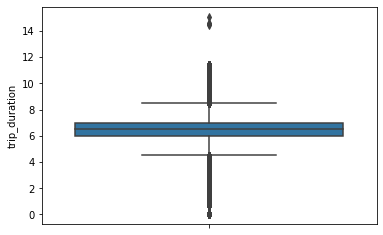

In [7]:
sns.boxplot(data = train, y = 'trip_duration')

In [8]:
#Only keep trips that lasted less than 5000 seconds
train = train[train['trip_duration'] < 5000]

In [9]:
#Only keep trips with passengers
train = train[train['passenger_count'] > 0]

<AxesSubplot:xlabel='pickup_latitude', ylabel='pickup_longitude'>

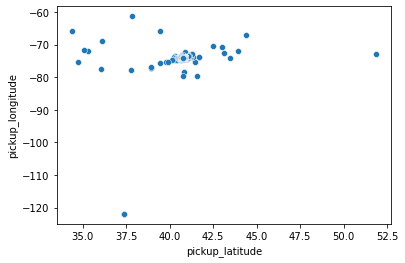

In [10]:
sns.scatterplot(data = train, x = 'pickup_latitude', y = 'pickup_longitude')

In [11]:
train = train[train['pickup_latitude'] < 50]
train = train[train['pickup_longitude'] > -100]

# Feature Processing and Engineering

In [12]:
categorical_columns = []
categorical_dims =  {}
for col in ['vendor_id', 'store_and_fwd_flag']:
    print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = l_enc.fit_transform(train[col].values)
    test[col] = l_enc.transform(test[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

vendor_id 2
store_and_fwd_flag 2


In [13]:
train['month'] = train.pickup_datetime.dt.month
train['week'] = train.pickup_datetime.dt.isocalendar().week
train['weekday'] = train.pickup_datetime.dt.isocalendar().day
train['hour'] = train.pickup_datetime.dt.hour
train['minute'] = train.pickup_datetime.dt.minute
train['minute_oftheday'] = train['hour'] * 60 + train['minute']
train = train.drop(columns = ['minute'])

test['month'] = test.pickup_datetime.dt.month
test['week'] = test.pickup_datetime.dt.isocalendar().week
test['weekday'] = test.pickup_datetime.dt.isocalendar().day
test['hour'] = test.pickup_datetime.dt.hour
test['minute'] = test.pickup_datetime.dt.minute
test['minute_oftheday'] = test['hour'] * 60 + test['minute']
test = test.drop(columns = ['minute'])

train = train.drop(columns = ['pickup_datetime'])
test = test.drop(columns = ['pickup_datetime'])

In [14]:
def ft_haversine_distance(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371 #km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

#Add distance feature
train['distance'] = ft_haversine_distance(train['pickup_latitude'].values,
                                          train['pickup_longitude'].values, 
                                          train['dropoff_latitude'].values,
                                          train['dropoff_longitude'].values)

test['distance'] = ft_haversine_distance(test['pickup_latitude'].values, 
                                         test['pickup_longitude'].values, 
                                         test['dropoff_latitude'].values, 
                                         test['dropoff_longitude'].values)

In [15]:
def ft_degree(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371 #km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

train['direction'] = ft_degree(train['pickup_latitude'].values,
                               train['pickup_longitude'].values,
                               train['dropoff_latitude'].values,
                               train['dropoff_longitude'].values)

test['direction'] = ft_degree(test['pickup_latitude'].values,
                              test['pickup_longitude'].values, 
                              test['dropoff_latitude'].values,
                              test['dropoff_longitude'].values)

In [6]:
train['trip_duration'] = np.log(train['trip_duration'].values)

# Outliers Part 2

<AxesSubplot:ylabel='distance'>

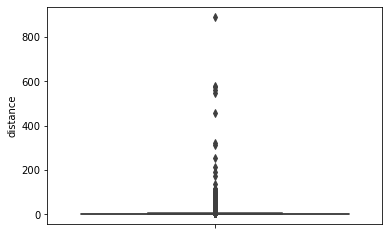

In [16]:
sns.boxplot(data = train, y = 'distance')

In [17]:
train = train[train['distance'] < 200]

In [18]:
train['speed'] = train['distance'] / train['trip_duration']

<AxesSubplot:ylabel='speed'>

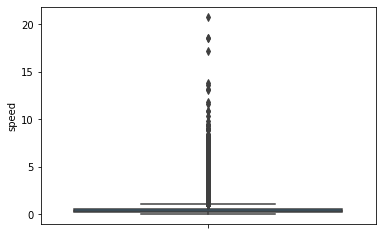

In [19]:
sns.boxplot(data = train, y = 'speed')

In [20]:
train = train[train['speed'] < 30]
train = train.drop(columns = ['speed'])

In [21]:
train = train.reset_index().drop(columns = 'index')
test = test.reset_index().drop(columns = 'index')

# Modeling

In [23]:
target_column = 'trip_duration'

unused_features = ['id']

feature_columns = [col for col in train.columns if col not in unused_features+[target_column]]

cat_idxs = [ i for i, f in enumerate(feature_columns) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(feature_columns) if f in categorical_columns]

In [38]:
MODEL_DIR = './model'

IS_TRAIN = True
SKIP_EXISTING_TRIALS = True

NFOLDS = 5 # 10
NSEEDS = 1 # 3

In [25]:
@dask.delayed
def run_training_tabnet(train, test, t_idx, v_idx, cat_idxs, cat_dims, fold, seed, filename = 'tabnet'):
    ## Important
    import torch
    
    train_df = train.loc[t_idx,:].reset_index(drop=True)
    valid_df = train.loc[v_idx,:].reset_index(drop=True)

    x_train, y_train  = train_df[feature_columns].values.astype(float), train_df[target_column].values.reshape(-1, 1).astype(float)
    x_valid, y_valid =  valid_df[feature_columns].values.astype(float), valid_df[target_column].values.reshape(-1, 1).astype(float)
    x_test = test[feature_columns].values.astype(float)
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
        
    model = TabNetRegressor(n_d=32, 
                            n_a=32, 
                            n_steps=1, 
                            lambda_sparse=0,
                            cat_dims=cat_dims, 
                            cat_emb_dim=1, 
                            cat_idxs=cat_idxs,
                            optimizer_fn=torch.optim.Adam, 
                            optimizer_params=dict(lr=2e-2, weight_decay=1e-5),
                            mask_type='entmax',
                            scheduler_params=dict(milestones=[100, 150], gamma=0.9),
                            scheduler_fn=torch.optim.lr_scheduler.MultiStepLR,
                            verbose=1,
                            seed = seed)
    
    model.fit(X_train=x_train, 
                  y_train=y_train,
                  eval_set=[(x_valid, y_valid)],
                  eval_metric=['rmsle'],
                  max_epochs=100, 
                  patience=5, 
                  batch_size=1024, 
                  virtual_batch_size=128,
                  num_workers=0, 
                  drop_last=False
                  )
    
    model.save_model(f"{MODEL_DIR}/{filename}_SEED{seed}_FOLD{fold}")
    
    
    valid_preds = model.predict(x_valid)
    
    oof = np.zeros((len(train),1))    
    oof[v_idx] = valid_preds
        
    predictions = model.predict(x_test)
    
    return oof, predictions

In [26]:
def run_k_fold_training(train, test, feature_columns, target_column, cat_idxs, cat_dims, NFOLDS, NSEEDS):    
    seed_list = range(NSEEDS)
    
    results = []
    
    for seed in seed_list:
        
        kf = KFold(n_splits=NFOLDS, shuffle=True, random_state = seed)
        
        for f, (t_idx, v_idx) in enumerate(kf.split(X=train[feature_columns], y=train[target_column])):

            
            train_scatterd = client.scatter(train)
            test_scattered = client.scatter(test)

            results.append(run_training_tabnet(train_scatterd, test_scattered, t_idx, v_idx, cat_idxs, cat_dims, f, seed))
            
#             results.append(run_training_tabnet(train, test, t_idx, v_idx, cat_idxs, cat_dims, f, seed))
        
    return(results)

In [27]:
result = run_k_fold_training(train, test, feature_columns, target_column, cat_idxs, cat_dims, NFOLDS, NSEEDS)

In [ ]:
results = dask.compute(result)

In [ ]:
np.save('results', results)

/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [22]:
results = np.load('results.npy', allow_pickle = True)

In [ ]:
oof = np.zeros((len(train),1))
prediction = np.zeros((len(test),1))

for result in results[0]:
    oof += result[0]
    prediction += result[1]
    
oof = oof/NSEEDS
prediction = prediction/NFOLDS/NSEEDS

In [43]:
mean_squared_log_error(train[target_column], oof)

0.15698218381731546

In [58]:
submission = pd.DataFrame({'id': test['id'].values, 'trip_duration': pd.DataFrame(prediction)[0]})

In [59]:
submission

,id,trip_duration
0,id3004672,890.489380
1,id3505355,693.313774
2,id1217141,456.643697
3,id2150126,1017.616895
4,id1598245,429.000618
...,...,...
625129,id3008929,380.426935
625130,id3700764,1290.492025
625131,id2568735,1545.446989
625132,id1384355,2077.156820


In [60]:
submission.to_csv("sub.csv", index=False)

# LightGBM Comparison

In [33]:
!pip install -q lightgbm

In [64]:
import lightgbm as lgb

In [78]:
lgb_params = {
    #'metric' : 'rmse',
    'learning_rate': 0.1,
    'max_depth': 25,
    'num_leaves': 1000, 
    'objective': 'regression',
    'feature_fraction': 0.9,
    'bagging_fraction': 0.5,
    'max_bin': 1000 }

In [79]:
lgb_df = lgb.Dataset(train[feature_columns].astype(float), train[target_column])
lgb_model = lgb.train(lgb_params, lgb_df, num_boost_round=1500)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6999
[LightGBM] [Info] Number of data points in the train set: 1454798, number of used features: 14
[LightGBM] [Info] Start training from score 6.455151


In [80]:
predictions = lgb_model.predict(test[feature_columns].astype(float))

In [81]:
submission = pd.DataFrame({'id': test.id, 'trip_duration': np.exp(predictions)})
submission.head()

,id,trip_duration
0,id3004672,784.330456
1,id3505355,583.730802
2,id1217141,472.631546
3,id2150126,864.395165
4,id1598245,375.591418


In [82]:
submission.to_csv("sub2.csv", index=False)